In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from IPython.display import clear_output
from ipywidgets import interact

plt.ion()

In [3]:
# Constants
DIM = 16
IN = DIM**2
HIDDEN = 60
OUT = 2
ACTIONS = 2
GAMMA = 0.9

In [8]:
def arm(t1, target_point):
    img = np.zeros((DIM, DIM))
    #img = np.random.random_sample((DIM, DIM)) * .3 - .15
    l = DIM*.5
    x, y = int(DIM/2), int(DIM/2)
    xp, yp = x + int(np.cos(t1)*l), y + int(np.sin(t1)*l)
    dist = np.sqrt(np.square(np.cos(t1) - target_point[0]) + np.square(np.sin(t1) - target_point[1]))
    cv2.line(img, (x, y), (xp, yp), (1))
    return img, dist

<function __main__.graph>

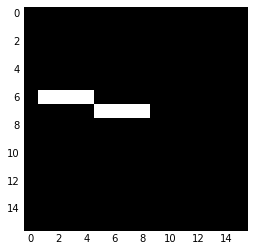

In [9]:
def graph(t1):
    data, dist = arm(t1, (1,0))
    plt.imshow(np.flipud(data), cmap=plt.cm.gray, interpolation='nearest')
    #print(dist)
    
interact(graph, t1=(0, 2*np.pi, .1))

In [10]:
def plot_avs(res=30):
    avs = []
    T = np.linspace(0, np.pi * 2.0, res)
    for t1 in T:
        data, dist = arm(t1, (0, 0))
        action_vals = y.eval(feed_dict={x: data.reshape((IN, 1))})
        avs.append(action_vals)

    avs = np.array(avs)
    plt.plot(T, avs[:,0], c='b')
    plt.plot(T, avs[:,1], c='r')

In [11]:
# Define network to predict action values

x = tf.placeholder(tf.float32, (IN, 1))

W1 = tf.Variable(tf.random_normal((HIDDEN, IN)))
b1 = tf.Variable(tf.random_normal((HIDDEN, 1)))

W2 = tf.Variable(tf.random_normal((OUT, HIDDEN)))
b2 = tf.Variable(tf.random_normal((OUT, 1)))

h1 = tf.nn.tanh(tf.matmul(W1, x) + b1)
y = tf.matmul(W2, h1) + b2

t = tf.placeholder(tf.float32, (OUT, 1))

cost = tf.reduce_mean(tf.square(t - y))

In [12]:
if 'session' in globals():
    session.close()

session = tf.InteractiveSession()
session.run(tf.initialize_all_variables())

In [17]:
train = tf.train.GradientDescentOptimizer(0.0001).minimize(cost)

0.0691123


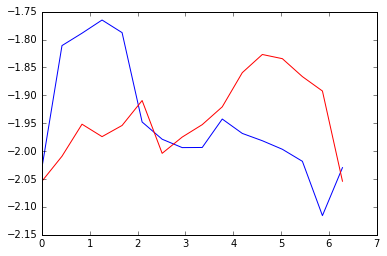

In [18]:
costs = []
t1s = []

def perform_action(theta, action_id):
    return theta + (action_id*2.0 - 1.0) * np.pi/8.0 # rotate left or right

target_point = (1, 0)

for i in range(10000):
    t1 = np.random.random_sample() * np.pi * 2.0
    
    data1, dist1 = arm(t1, target_point)
    
    rand_action = np.random.randint(ACTIONS)
    
    t1 = perform_action(t1, rand_action)
    
    t1s.append(t1)
    
    data2, dist2 = arm(t1, target_point)
    
    reward = (dist1 - dist2) / 2.0 - .5
    
    action_values = y.eval(feed_dict={x: data1.reshape((IN, 1))})
    action_values_p = y.eval(feed_dict={x: data2.reshape((IN, 1))})
    
    max_q = np.max(action_values_p)
    
    target_action_values = np.full_like(action_values, max_q) * GAMMA
    target_action_values[rand_action, 0] += reward
    
    session.run(train, feed_dict={x: data1.reshape((IN, 1)), t: target_action_values})
    
    if i%1000==0:
        clear_output(wait=True)
        c = cost.eval(feed_dict={x: data1.reshape((IN, 1)), t: target_action_values})
        print(c)
        plot_avs(res=16)
        plt.show()
        costs.append(c)

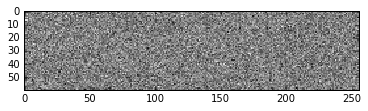

In [19]:
plt.imshow(W1.eval(session), cmap=plt.cm.gray, interpolation='nearest')

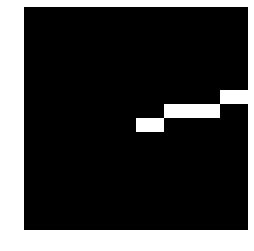

In [22]:
# Rollout of agent's behavior!

from matplotlib import gridspec

for run in range(10):
    t1 = np.random.random_sample() * np.pi * 2.0
    for i in range(15):
        data, _ = arm(t1, (1, 0))
        action_values = y.eval(feed_dict={x: data.reshape((IN, 1))})
        best_action = np.argmax(action_values)

        # perform best action
        t1 = perform_action(t1, best_action)

        data_p, dist = arm(t1, (1, 0))

        clear_output(wait=True)
        #print(action_values, np.argmax(action_values))
        #gs = gridspec.GridSpec(1, 2)
        #plt.figure(figsize=(16,4))

        #plt.subplot(gs[0])
        plt.axis('off')
        plt.imshow(data_p, interpolation='nearest', cmap=plt.cm.gray)

        #h1_act = h1.eval(feed_dict={x: data.reshape((IN, 1))})

        #plt.subplot(gs[1])
        #plt.scatter(range(len(h1_act)), h1_act)

        #plt.subplot(gs[1])
        #plt.axis('off')
        #plt.plot(action_values)

        plt.show()